<a href="https://colab.research.google.com/github/kartickgupta/shared-task-2021/blob/main/Shared_Task_2021_RoBERTa_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct  1 07:20:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    46W / 250W |  15855MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install textaugment
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from textaugment import Wordnet, EDA, word2vec, Translate
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text
from tqdm import tqdm

In [ ]:
!pip3 install transformers

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/MyDrive/Shared-Task-2021/global-headline-only.csv', 'r') as f:
    df = pd.read_csv(f)

df.head()

,data_id,event_date,year,event_type,sub_event_type,region,country,location,notes,cleaned,lemmatized,stemmed
0,8378880,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Arnaba,"On 9 July 2021, regime forces shelled Arnaba t...",regime forces shelled Arnaba town in Idleb cou...,regime force shelled arnaba town idleb country...,regim forc shell arnaba town idleb countrysid ...
1,8378881,09-07-2021,2021,Explosions/Remote violence,Shelling/artillery/missile attack,Middle East,Syria,Balyun,"On 9 July 2021, regime forces shelled Balyun t...",regime forces shelled Balyun town and its vici...,regime force shelled balyun town vicinity idle...,regim forc shell balyun town vicin idleb count...
2,8381441,09-07-2021,2021,Protests,Peaceful protest,East Asia,South Korea,Jinju,"On 9 July 2021, local veterans' organizations,...",local veterans organizations including the Kor...,local veteran organization including korean wa...,local veteran organ includ korean war veteran ...
3,8383746,09-07-2021,2021,Riots,Violent demonstration,South Asia,Pakistan,Larkana,"On 9 July 2021, prisoners held a demonstration...",prisoners held a demonstration and set wood an...,prisoner held demonstration set wood clothes f...,prison held demonstr set wood cloth fire larka...
4,8381699,09-07-2021,2021,Violence against civilians,Attack,Southeast Asia,Myanmar,Hpa Yar Gyi,"On 9 July 2021, in Hpa Yar Gyi village (Thongw...",in Hpa Yar Gyi village the village administra...,hpa yar gyi village village administrator shot...,hpa yar gyi villag villag administr shot three...


In [ ]:
df.sub_event_type.value_counts()

Peaceful protest                       329399
Armed clash                            239828
Attack                                 132202
Shelling/artillery/missile attack       64743
Mob violence                            42079
Violent demonstration                   41003
Air/drone strike                        34020
Protest with intervention               31784
Remote explosive/landmine/IED           30620
Looting/property destruction            24315
Abduction/forced disappearance          14624
Arrests                                  8668
Change to group/activity                 7925
Disrupted weapons use                    7499
Government regains territory             6148
Other                                    5353
Excessive force against protesters       3098
Grenade                                  2948
Non-state actor overtakes territory      2670
Sexual violence                          2196
Agreement                                1460
Non-violent transfer of territory 

In [ ]:
df.drop_duplicates(['lemmatized']).sub_event_type.value_counts()

Peaceful protest                       305383
Armed clash                             96231
Attack                                  65363
Shelling/artillery/missile attack       33279
Violent demonstration                   24574
Mob violence                            21098
Air/drone strike                        18620
Remote explosive/landmine/IED           16110
Protest with intervention               15003
Looting/property destruction            12036
Abduction/forced disappearance           7214
Change to group/activity                 7098
Arrests                                  4238
Disrupted weapons use                    3866
Other                                    3698
Government regains territory             2424
Grenade                                  1530
Excessive force against protesters       1520
Non-state actor overtakes territory      1198
Sexual violence                          1027
Agreement                                 692
Non-violent transfer of territory 

In [ ]:
event_types_dict = {}
for num, name in enumerate(list(df['sub_event_type'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Shelling/artillery/missile attack': 0, 'Peaceful protest': 1, 'Violent demonstration': 2, 'Attack': 3, 'Air/drone strike': 4, 'Armed clash': 5, 'Mob violence': 6, 'Protest with intervention': 7, 'Excessive force against protesters': 8, 'Looting/property destruction': 9, 'Other': 10, 'Remote explosive/landmine/IED': 11, 'Government regains territory': 12, 'Abduction/forced disappearance': 13, 'Change to group/activity': 14, 'Non-state actor overtakes territory': 15, 'Arrests': 16, 'Sexual violence': 17, 'Disrupted weapons use': 18, 'Non-violent transfer of territory': 19, 'Grenade': 20, 'Headquarters or base established': 21, 'Suicide bomb': 22, 'Agreement': 23, 'Chemical weapon': 24}
{0: 'Shelling/artillery/missile attack', 1: 'Peaceful protest', 2: 'Violent demonstration', 3: 'Attack', 4: 'Air/drone strike', 5: 'Armed clash', 6: 'Mob violence', 7: 'Protest with intervention', 8: 'Excessive force against protesters', 9: 'Looting/property destruction', 10: 'Other', 11: 'Remote explosi

In [ ]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Peaceful protest'))
df['labels'] = df['sub_event_type'].apply(text_to_numerical_category)

1


In [ ]:
df.drop(columns=['data_id', 'event_date', 'year','event_type','region','country', 'location',	'notes','cleaned', 'stemmed'	], inplace=True)

In [ ]:
df.head()

,sub_event_type,lemmatized,labels
0,Shelling/artillery/missile attack,regime force shelled arnaba town idleb country...,0
1,Shelling/artillery/missile attack,regime force shelled balyun town vicinity idle...,0
2,Peaceful protest,local veteran organization including korean wa...,1
3,Violent demonstration,prisoner held demonstration set wood clothes f...,2
4,Attack,hpa yar gyi village village administrator shot...,3


## Handling Imbalanced Dataset

In [ ]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 20000
THRESH_2 = 10000
THRESH_3 = 1000

for group in df.sub_event_type.unique():
    # Having More Than 20K
    if len(df.groupby('sub_event_type').get_group(group).lemmatized.unique()) > THRESH_1:
        lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized.unique()))[:THRESH_1])
        labels += ([group]*THRESH_1)
     # Having Unique b/w 20K and 10K - Take top 20K from all
    elif len(df.groupby('sub_event_type').get_group(group).lemmatized.unique()) < THRESH_1 and len(df.groupby('sub_event_type').get_group(group).lemmatized.unique()) > THRESH_2:
       lemm += (list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))[:THRESH_1])
       labels += ([group]*THRESH_1)
    # Having b/w 20K and 5K - take all
    elif len(df.groupby('sub_event_type').get_group(group).lemmatized) < 20000 and len(df.groupby('sub_event_type').get_group(group).lemmatized) > 5000:
       lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))
       labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))))
     # Having Less Than 1K - Multipy by 6
    elif len(df.groupby('sub_event_type').get_group(group).lemmatized) < THRESH_3:
        for i in range(6):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))))
    # Remaining - Multiply by 2
    else:
         for i in range(2):
            lemm += list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))
            labels += ([group]*len(list(shuffle(df.groupby('sub_event_type').get_group(group).lemmatized))))


In [ ]:
len(lemm)

286631

In [ ]:
len(labels)

286631

In [ ]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [ ]:
balanced_df.head()

,Text,Labels
0,prohouthi force reportedly fired mm machine gu...,Shelling/artillery/missile attack
1,prohouthi force claimed destroyed military veh...,Shelling/artillery/missile attack
2,prohadi force assistance saudiled coalition re...,Shelling/artillery/missile attack
3,january osce smm observed total explosionsburs...,Shelling/artillery/missile attack
4,prohouthi force reportedly shelled alqardayn v...,Shelling/artillery/missile attack


In [ ]:
event_types_dict_new = {}
for num, name in enumerate(list(balanced_df.Labels.unique())):
    event_types_dict_new[name] = num
    # print(name, " : ", num)

event_types_dict_new

event_types_dict_inverse_new = {k:v for v,k in event_types_dict_new.items()}
print(event_types_dict_new)
print( event_types_dict_inverse_new)

{'Shelling/artillery/missile attack': 0, 'Peaceful protest': 1, 'Violent demonstration': 2, 'Attack': 3, 'Air/drone strike': 4, 'Armed clash': 5, 'Mob violence': 6, 'Protest with intervention': 7, 'Excessive force against protesters': 8, 'Looting/property destruction': 9, 'Other': 10, 'Remote explosive/landmine/IED': 11, 'Government regains territory': 12, 'Abduction/forced disappearance': 13, 'Change to group/activity': 14, 'Non-state actor overtakes territory': 15, 'Arrests': 16, 'Sexual violence': 17, 'Disrupted weapons use': 18, 'Non-violent transfer of territory': 19, 'Grenade': 20, 'Headquarters or base established': 21, 'Suicide bomb': 22, 'Agreement': 23, 'Chemical weapon': 24}
{0: 'Shelling/artillery/missile attack', 1: 'Peaceful protest', 2: 'Violent demonstration', 3: 'Attack', 4: 'Air/drone strike', 5: 'Armed clash', 6: 'Mob violence', 7: 'Protest with intervention', 8: 'Excessive force against protesters', 9: 'Looting/property destruction', 10: 'Other', 11: 'Remote explosi

## Event Frequency comparison w/ Original and Augmented Data.

In [ ]:
df.sub_event_type.value_counts()

Peaceful protest                       329399
Armed clash                            239828
Attack                                 132202
Shelling/artillery/missile attack       64743
Mob violence                            42079
Violent demonstration                   41003
Air/drone strike                        34020
Protest with intervention               31784
Remote explosive/landmine/IED           30620
Looting/property destruction            24315
Abduction/forced disappearance          14624
Arrests                                  8668
Change to group/activity                 7925
Disrupted weapons use                    7499
Government regains territory             6148
Other                                    5353
Excessive force against protesters       3098
Grenade                                  2948
Non-state actor overtakes territory      2670
Sexual violence                          2196
Agreement                                1460
Non-violent transfer of territory 

In [ ]:
balanced_df.Labels.value_counts()

Looting/property destruction           20000
Attack                                 20000
Remote explosive/landmine/IED          20000
Violent demonstration                  20000
Armed clash                            20000
Air/drone strike                       20000
Shelling/artillery/missile attack      20000
Protest with intervention              20000
Peaceful protest                       20000
Mob violence                           20000
Abduction/forced disappearance         14624
Arrests                                 8668
Change to group/activity                7925
Disrupted weapons use                   7499
Excessive force against protesters      6196
Government regains territory            6148
Non-violent transfer of territory       5934
Grenade                                 5896
Other                                   5353
Non-state actor overtakes territory     5340
Sexual violence                         4392
Suicide bomb                            3810
Agreement 

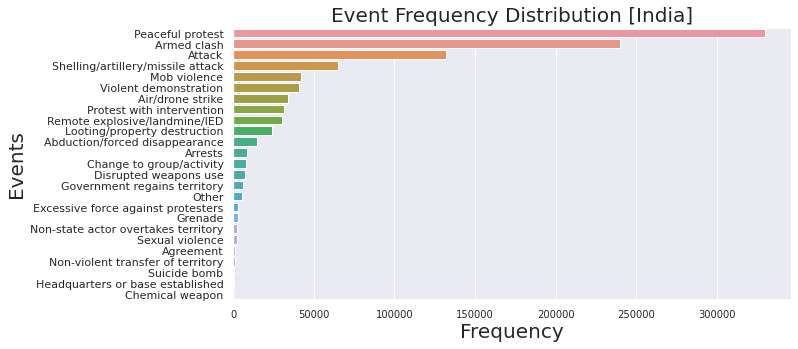

In [ ]:
sns.set_theme(style="darkgrid")
x = df['sub_event_type'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

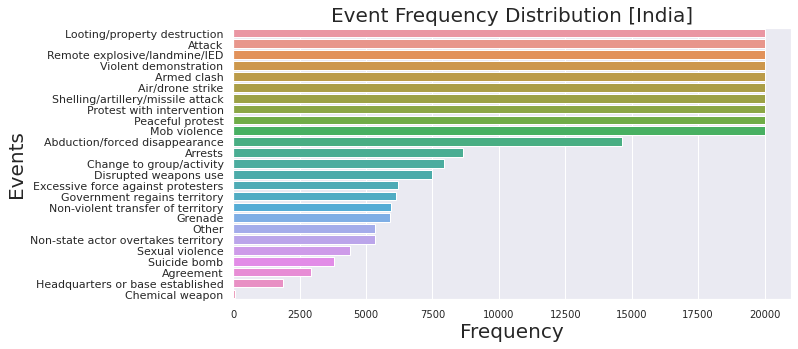

In [ ]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

In [ ]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [ ]:
balanced_df.head()

,Text,Labels,NumLabel
0,prohouthi force reportedly fired mm machine gu...,Shelling/artillery/missile attack,0
1,prohouthi force claimed destroyed military veh...,Shelling/artillery/missile attack,0
2,prohadi force assistance saudiled coalition re...,Shelling/artillery/missile attack,0
3,january osce smm observed total explosionsburs...,Shelling/artillery/missile attack,0
4,prohouthi force reportedly shelled alqardayn v...,Shelling/artillery/missile attack,0


# RoBERTa

In [ ]:
max_classes = len(balanced_df.Labels.unique())
max_length = 128

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification

# Same as before
checkpoint = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(checkpoint, max_length=max_length)

## Hyperparametrs

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate=0.,
                               decay_steps=num_train_steps
                               )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

## Tokenization

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result_df = shuffle(balanced_df)

In [ ]:
result_df

,Text,Labels,NumLabel
88258,turkish warplane conducted airstrikes tal bayd...,Air/drone strike,4
164239,large group protester gathered mong kok yau ts...,Excessive force against protesters,8
209407,august houthiplanted ied reportedly detonated ...,Remote explosive/landmine/IED,11
43996,people demonstrated police violence marched lo...,Violent demonstration,2
12166,november osce smm observed total explosion inv...,Shelling/artillery/missile attack,0
...,...,...,...
210894,ied planted unknown armed group exploded behin...,Remote explosive/landmine/IED,11
23678,hpa yar ngar su village win yaw area villager ...,Peaceful protest,1
157584,people baltimore bloc marched baltimore black ...,Protest with intervention,7
199435,three civilian one family injured unidentified...,Remote explosive/landmine/IED,11


In [ ]:
# result_df.to_csv('resampled-training-data.csv', index=True)

In [ ]:
result_df = pd.read_csv('/content/drive/MyDrive/Shared-Task-2021/resampled-training-data-ggod.csv', index_col=0)
# result_df

### Train-Test-Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(result_df.Text, result_df.NumLabel, test_size = 0.1, random_state = 42, stratify =result_df.NumLabel)

### Label Encoding

In [ ]:
max_classes = len(balanced_df.Labels.unique())
print(max_classes)

25


In [ ]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 14.1 ms, sys: 1.72 ms, total: 15.8 ms
Wall time: 14.6 ms


### Input-Tokenization

In [ ]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
%%time
train_inputs,train_attention_masks = roberta_encode(list(X_train), max_length)

  0%|          | 0/257967 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 257967/257967 [02:33<00:00, 1681.12it/s]


CPU times: user 2min, sys: 2.58 s, total: 2min 2s
Wall time: 2min 39s


In [ ]:
test_inputs,test_attention_masks = roberta_encode(list(X_test), max_length)

  0%|          | 0/28664 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 28664/28664 [00:12<00:00, 2361.52it/s]


In [ ]:
# train_inputs = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="np")

# train_inputs["labels"] = tf.reshape(tf.constant(encoded_labels_train), (len(list(X_train)), max_classes))

In [ ]:
len(X_train), len(X_test)

(257967, 28664)

In [ ]:
# test_inputs = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="np")

# test_inputs["labels"] = tf.reshape(tf.constant(encoded_labels_test), (len(list(X_test)), max_classes)) 

### Tensorflow-Input-Pipeline

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_inputs,train_attention_masks), encoded_labels_train)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_inputs,test_attention_masks), encoded_labels_test)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Custom Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('RoBERTa-base.h5',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

mkdir: cannot create directory ‘checkpoints’: File exists


True

## Class Weight Balancing

In [ ]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight('balanced'
                                               ,np.unique(balanced_df.NumLabel)
                                               ,balanced_df.NumLabel)

class_weights_array

array([  0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         0.573262  ,   0.573262  ,   0.573262  ,   0.573262  ,
         1.85042608,   0.573262  ,   2.14183449,   0.573262  ,
         1.86487313,   0.78400164,   1.44671798,   2.14704869,
         1.32270881,   2.6104827 ,   1.52890252,   1.93212673,
         1.94457938,   6.14428725,   3.00924934,   3.92645205,
       191.08733333])

In [ ]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.573262,
 1: 0.573262,
 2: 0.573262,
 3: 0.573262,
 4: 0.573262,
 5: 0.573262,
 6: 0.573262,
 7: 0.573262,
 8: 1.8504260813428017,
 9: 0.573262,
 10: 2.141834485335326,
 11: 0.573262,
 12: 1.8648731294729994,
 13: 0.7840016411378555,
 14: 1.4467179810725552,
 15: 2.1470486891385767,
 16: 1.322708814028611,
 17: 2.6104826958105645,
 18: 1.528902520336045,
 19: 1.9321267273340075,
 20: 1.9445793758480325,
 21: 6.144287245444802,
 22: 3.009249343832021,
 23: 3.9264520547945208,
 24: 191.08733333333333}

## Building Model

### Defining Model Metrics

In [ ]:
# !pip install tensorflow_addons
import tensorflow_addons as tfa

macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]


### Custom Model Creation

In [ ]:
def create_model(roberta_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
  output = roberta_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

## Model Summary

In [ ]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model = create_model(roberta_model)
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model_3 (TFRobertaMo TFBaseModelOutputWit 124645632   input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           24608       tf_roberta_model_3[0][1]   

## Model Training

In [ ]:
%%time
history = model.fit([train_inputs,train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inputs, test_attention_masks], encoded_labels_test),
                    epochs = EPOCHS,
                    batch_size = batch_size,
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
8062/8062 [==============================] - 4102s 506ms/step - loss: 0.9153 - categorical_accuracy: 0.7533 - f1_score: 0.7492 - val_loss: 0.4424 - val_categorical_accuracy: 0.8923 - val_f1_score: 0.8939

Epoch 00001: val_categorical_accuracy improved from -inf to 0.89234, saving model to RoBERTa-base.h5
Epoch 2/3
8062/8062 [==============================] - 4074s 505ms/step - loss: 0.4927 - categorical_accuracy: 0.8789 - f1_score: 0.8767 - val_loss: 0.3644 - val_categorical_accuracy: 0.9134 - val_f1_score: 0.9137

Epoch 00002: val_categorical_accuracy improved from 0.89234 to 0.91341, saving model to RoBERTa-base.h5
Epoch 3/3
8062/8062 [==============================] - 4072s 505ms/step - loss: 0.3891 - categorical_accuracy: 0.9022 - f1_score: 0.9009 - val_loss: 0.9131 - val_categorical_accuracy: 0.8140 - val_f1_score: 0.8235

Epoch 00003: val_categorical_accuracy did not improve from 0.91341
Restoring model weights from the end of the best epoch.
Epoch 00003: early stopping

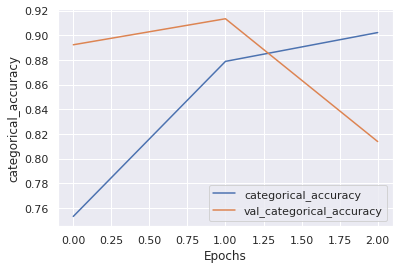

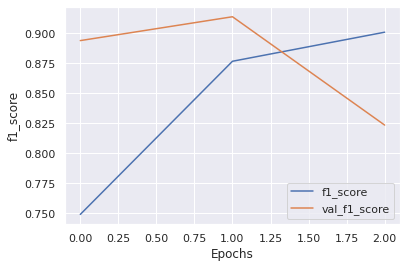

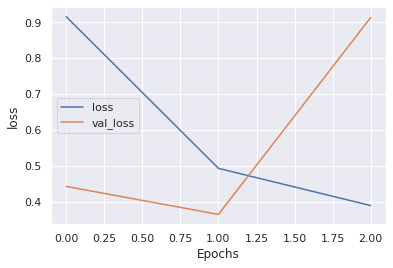

In [ ]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, "f1_score")
plot_graphs(history, 'loss')


In [ ]:
model.save('BERT-Model.h5')

In [ ]:
test_file = pd.read_csv('/content/test_file_with labels.txt', sep='\t')

In [ ]:
test_file.head()

,id,EventSnippet,SubType
0,1,The US warplanes pounded the village of Kashka...,AIR_STRIKE
1,2,After a five-week drop of Covid-19 cases in Pu...,NATURAL_DISASTER
2,3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST
3,4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER
4,5,Vice-President Mike Pence said Thursday that t...,AGREEMENT


In [ ]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result


In [ ]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['EventSnippet'].apply(text_cleaning)

In [ ]:
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
test_file.head()

,id,EventSnippet,SubType,processed
0,1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,u warplane pounded village kashkash southern p...
1,2,After a five-week drop of Covid-19 cases in Pu...,NATURAL_DISASTER,five-week drop covid- case punjab number peopl...
2,3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officer brutally attacked injured peaceful stu...
3,4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isi fighter recaptured village kashma syrian a...
4,5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike penny said thursday mainly...


In [ ]:
final_test_inputs, final_test_attention_masks = roberta_encode(list(test_file.processed), max_length)

  0%|          | 0/1019 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 1019/1019 [00:00<00:00, 1920.13it/s]


In [ ]:
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

In [ ]:
y_preds

array([ 4, 10,  8, ...,  5, 13, 15])

In [ ]:
test_file['pred-labels'] = y_preds

In [ ]:
test_file.head()

,id,EventSnippet,SubType,processed,pred-labels
0,1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,u warplane pounded village kashkash southern p...,4
1,2,After a five-week drop of Covid-19 cases in Pu...,NATURAL_DISASTER,five-week drop covid- case punjab number peopl...,10
2,3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officer brutally attacked injured peaceful stu...,8
3,4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isi fighter recaptured village kashma syrian a...,15
4,5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike penny said thursday mainly...,23


In [ ]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text-labels'] = test_file['pred-labels'].apply(num_to_text_labels)

In [ ]:
correct_format = ['ABDUCT_DISSAP',
'AGREEMENT',
'AIR_STRIKE',
'ARMED_CLASH',
'ARREST',
'ART_MISS_ATTACK',
'ATTACK',
'CHANGE_TO_GROUP_ACT',
'CHEM_WEAP',
'DISR_WEAP',
'FORCE_AGAINST_PROTEST',
'GOV_REGAINS_TERIT',
'GRENADE',
'HQ_ESTABLISHED',
'MOB_VIOL',
'NON_STATE_ACTOR_OVERTAKES_TER',
'NON_VIOL_TERRIT_TRANSFER',
'OTHER',
'PEACE_PROTEST',
'PROPERTY_DISTRUCT',
'PROTEST_WITH_INTER',
'REM_EXPLOS',
'SEX_VIOL',
'SUIC_BOMB',
'VIOL_DEMONSTR']

In [ ]:
dict_list = list(event_types_dict.keys())

In [ ]:
dict_list

correct_format_dict = {'Abduction/forced disappearance':'ABDUCT_DISSAP',
                       'Agreement': 'AGREEMENT',
                        'Air/drone strike' : 'AIR_STRIKE',
                         'Armed clash' : 'ARMED_CLASH',
                       'Arrests' : 'ARREST',
                       'Attack' : 'ATTACK',
                       'Change to group/activity' : 'CHANGE_TO_GROUP_ACT',
                       'Chemical weapon' : 'CHEM_WEAP',
                       'Disrupted weapons use' : 'DISR_WEAP',
                       'Excessive force against protesters' : 'FORCE_AGAINST_PROTEST',
                       'Government regains territory' : 'GOV_REGAINS_TERIT',
                       'Grenade' : 'GRENADE',
                        'Headquarters or base established' : 'HQ_ESTABLISHED',
                       'Looting/property destruction' : 'PROPERTY_DISTRUCT',
                       'Mob violence' : 'MOB_VIOL',
                       'Non-state actor overtakes territory' : 'NON_STATE_ACTOR_OVERTAKES_TER',
                       'Non-violent transfer of territory' : 'NON_VIOL_TERRIT_TRANSFER',
                       'Other' : 'OTHER',
                        'Peaceful protest' : 'PEACE_PROTEST',
                       'Protest with intervention' : 'PROTEST_WITH_INTER',
                       'Remote explosive/landmine/IED' : 'REM_EXPLOS',
                       'Sexual violence' : 'SEX_VIOL',
                       'Shelling/artillery/missile attack' : 'ART_MISS_ATTACK',
                       'Suicide bomb' : 'SUIC_BOMB',
                        'Violent demonstration' : 'VIOL_DEMONSTR'
                       }

In [ ]:
correct_format_dict

{'Abduction/forced disappearance': 'ABDUCT_DISSAP',
 'Agreement': 'AGREEMENT',
 'Air/drone strike': 'AIR_STRIKE',
 'Armed clash': 'ARMED_CLASH',
 'Arrests': 'ARREST',
 'Attack': 'ATTACK',
 'Change to group/activity': 'CHANGE_TO_GROUP_ACT',
 'Chemical weapon': 'CHEM_WEAP',
 'Disrupted weapons use': 'DISR_WEAP',
 'Excessive force against protesters': 'FORCE_AGAINST_PROTEST',
 'Government regains territory': 'GOV_REGAINS_TERIT',
 'Grenade': 'GRENADE',
 'Headquarters or base established': 'HQ_ESTABLISHED',
 'Looting/property destruction': 'PROPERTY_DISTRUCT',
 'Mob violence': 'MOB_VIOL',
 'Non-state actor overtakes territory': 'NON_STATE_ACTOR_OVERTAKES_TER',
 'Non-violent transfer of territory': 'NON_VIOL_TERRIT_TRANSFER',
 'Other': 'OTHER',
 'Peaceful protest': 'PEACE_PROTEST',
 'Protest with intervention': 'PROTEST_WITH_INTER',
 'Remote explosive/landmine/IED': 'REM_EXPLOS',
 'Sexual violence': 'SEX_VIOL',
 'Shelling/artillery/missile attack': 'ART_MISS_ATTACK',
 'Suicide bomb': 'SUIC_B

In [ ]:
def correct_format(text):
    correct_label = correct_format_dict[text]
    return correct_label

test_file['correct-labels'] = test_file['text-labels'].apply(correct_format)

In [ ]:
test_file.head()

,id,EventSnippet,SubType,processed,pred-labels,text-labels,correct-labels
0,1,The US warplanes pounded the village of Kashka...,AIR_STRIKE,u warplane pounded village kashkash southern p...,4,Air/drone strike,AIR_STRIKE
1,2,After a five-week drop of Covid-19 cases in Pu...,NATURAL_DISASTER,five-week drop covid- case punjab number peopl...,10,Other,OTHER
2,3,Officers brutally attacked and injured a peace...,FORCE_AGAINST_PROTEST,officer brutally attacked injured peaceful stu...,8,Excessive force against protesters,FORCE_AGAINST_PROTEST
3,4,"On December 13, ISIS fighters recaptured the v...",NON_STATE_ACTOR_OVERTAKES_TER,isi fighter recaptured village kashma syrian a...,15,Non-state actor overtakes territory,NON_STATE_ACTOR_OVERTAKES_TER
4,5,Vice-President Mike Pence said Thursday that t...,AGREEMENT,vice-president mike penny said thursday mainly...,23,Agreement,AGREEMENT


In [ ]:
test_file.to_csv('final.txt', sep='\t', index=False)

In [ ]:
trrr = pd.read_csv('final.tsv', sep='\t')

In [ ]:
trrr.head()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true= list(test_file.SubType), y_pred= list(test_file['correct-labels'])))

                               precision    recall  f1-score   support

                ABDUCT_DISSAP       0.57      0.85      0.68        20
                    AGREEMENT       1.00      0.74      0.85        31
                   AIR_STRIKE       0.86      0.67      0.75        36
                  ARMED_CLASH       0.76      0.64      0.69        66
                       ARREST       0.76      0.65      0.70        34
              ART_MISS_ATTACK       0.60      0.89      0.72        36
                       ATTACK       0.50      0.81      0.62        27
                       ATTRIB       0.00      0.00      0.00        28
          CHANGE_TO_GROUP_ACT       0.49      0.60      0.54        30
                    CHEM_WEAP       0.00      0.00      0.00        37
                        DIPLO       0.00      0.00      0.00        44
                    DISR_WEAP       0.92      0.79      0.85        58
        FORCE_AGAINST_PROTEST       0.38      0.61      0.47        23
     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
